In [0]:
!git clone https://github.com/1297rohit/RCNN

fatal: destination path 'RCNN' already exists and is not an empty directory.


In [0]:
!unzip /content/RCNN/Images.zip

Archive:  /content/RCNN/Images.zip
replace Images/airplane_007.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!unzip /content/RCNN/Airplanes_Annotations.zip

Archive:  /content/RCNN/Airplanes_Annotations.zip
replace Airplanes_Annotations/airplane_095.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import cv2 # to perform selective search on the images
import os, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
path = "Images"
annot = "Airplanes_Annotations"

airplane_401.jpg
Tọa độ máy bay trong ảnh:                   2
0      5 90 52 132
1  199 115 245 159


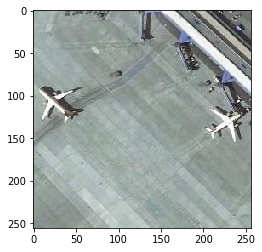

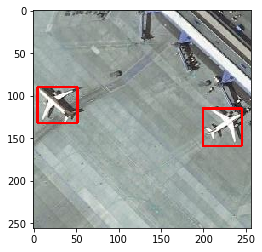

In [0]:
for e,i in enumerate(os.listdir(annot)):
  if e < 10:
      filename = i.split(".")[0]+".jpg"
      print(filename)
      img = cv2.imread(os.path.join(path,filename))
      df = pd.read_csv(os.path.join(annot,i))
      print('Tọa độ máy bay trong ảnh: ', df)
      plt.imshow(img)
      for row in df.iterrows():
          x1 = int(row[1][0].split(" ")[0])
          y1 = int(row[1][0].split(" ")[1])
          x2 = int(row[1][0].split(" ")[2])
          y2 = int(row[1][0].split(" ")[3])
          cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
      plt.figure()
      plt.imshow(img)
      break

In [0]:
# initialize selective search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [0]:
df = pd.read_csv(os.path.join(annot, '42850.csv'))
df

,2
0,106 95 135 131
1,1 162 16 193


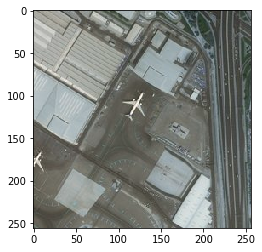

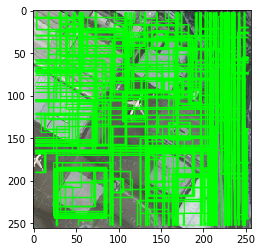

In [0]:
im = cv2.imread(os.path.join(path, "42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in enumerate(rects):
  x, y, w, h = rect
  cv2.rectangle(imOut, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(im)
plt.figure()
plt.imshow(imOut)

In [0]:
# caculate Intersection Over Union
def get_iou(bb1, bb2):
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
        return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)
  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0

  return iou


In [0]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else:
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [0]:
len(train_images)

30229

In [0]:
len(train_labels)

30229

In [0]:
# convert the array to numpy array so that we can traverse it easily and pass the data set to the model 
# in an efficient way
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [0]:
# transfer learning
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
for layer in (vggmodel.layers)[:15]:
  #print(layer)
  layer.trainable = False

X = vggmodel.layers[-2].output
predictions = Dense(2, activation='softmax')(X)
model_final = Model(input=vggmodel.input, output=predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss=keras.losses.categorical_crossentropy, 
                    optimizer=opt, metrics=['accuracy'])
model_final.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
train_labels = lenc.fit_transform(train_labels)
X_train, X_test , y_train, y_test = train_test_split(train_images, train_labels, test_size=0.10)

In [0]:
# do some data agumentation
#X_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90).flow(x=X_train, y=y_train)
#X_test = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90).flow(x=X_test, y=y_test)

In [0]:
# model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('ieeercnn_vgg16_1.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

# train
#history = model_final.fit_generator(generator=X_train, 
#                                    step_per_epoch=10,
#                                    epochs=1000,
#                                    validation_data=X_test, 
#                                    validation_step=2,
#                                    callbacks=[checkpoint, early])

model_final.fit(x=X_train, y=y_train, batch_size=32, epochs=1000, verbose=1,
                validation_data=(X_test, y_test),
                callbacks=[checkpoint, early])

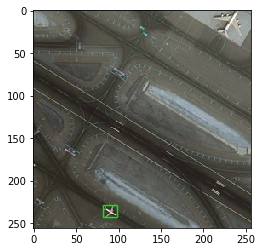

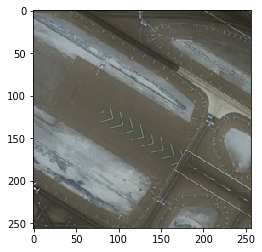

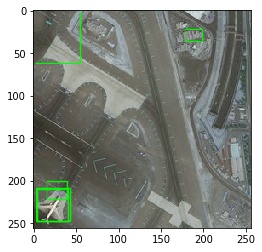

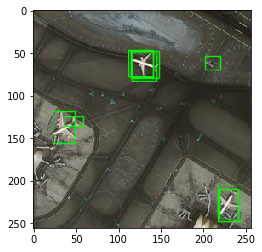

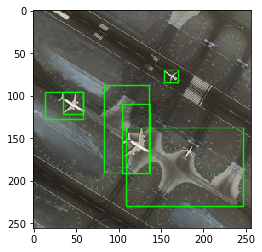

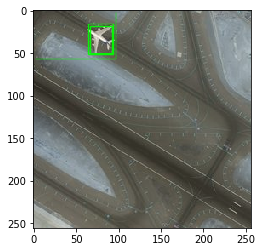

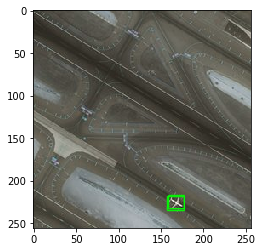

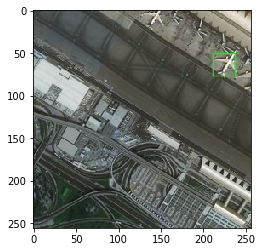

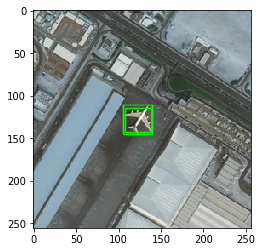

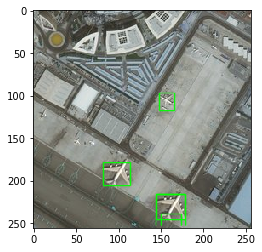

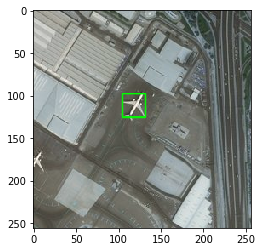

In [0]:
# predict
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        if z > 10:
          break